In [772]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

from pandas import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

import torch
import torch.nn as nn
from torch.autograd import Variable
import os
import optuna

seed = 211
np.random.seed(seed)

<ipython-input-772-88461a3b10a8>:9: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



In [773]:
filepath = 'input/NASDAQ_DAYLY.csv'
#d_parser = lambda x: pd.datetime.strptime(x, '%d/%m/%d')
nasdaq = pd.read_csv(filepath)
nasdaq['Date'] = pd.to_datetime(nasdaq['Date'], format = '%Y-%m-%d')
#data = data.sort_values('Date')
nasdaq = nasdaq.set_index('Date')
#nasdaq = nasdaq.sort_values(by='Date',ascending=False)
nasdaq = nasdaq[['Close']]
nasdaq

,Close
Date,
2002-12-18,1013.669983
2002-12-19,1006.049988
2002-12-20,1013.900024
2002-12-23,1032.300049
2002-12-24,1023.289978
...,...
2021-06-07,13802.889648
2021-06-08,13810.860352
2021-06-09,13814.940430


In [774]:
filepath = 'input/WALCL.csv'
#d_parser = lambda x: pd.datetime.strptime(x, '%d/%m/%d')
assets = pd.read_csv(filepath)
assets['DATE'] = pd.to_datetime(assets['DATE'], format = '%Y-%m-%d')
#data = data.sort_values('Date')
assets = assets.rename(columns={'DATE':'Date',"WALCL":'Millions_of_Dollars'})
assets.set_index('Date',inplace=True)
#assets.sort_values(by='DATE',ascending=False,inplace=True)
#(assets.index[1]-assets.index[0]).days
#assets.iloc[0]
assets

,Millions_of_Dollars
Date,
2002-12-18,719542.0
2002-12-25,732059.0
2003-01-01,730994.0
2003-01-08,723762.0
2003-01-15,720074.0
...,...
2021-05-12,7830663.0
2021-05-19,7922883.0
2021-05-26,7903541.0


In [775]:
#nasdaq = nasdaq.iloc[:assets.size]
nasdaq['Assets'] = assets['Millions_of_Dollars']
nasdaq = nasdaq.dropna()
nasdaq

,Close,Assets
Date,,
2002-12-18,1013.669983,719542.0
2003-01-08,1042.520020,723762.0
2003-01-15,1073.599976,720074.0
2003-01-22,1006.510010,735953.0
2003-01-29,1016.559998,712809.0
...,...,...
2021-05-12,13001.629883,7830663.0
2021-05-19,13237.910156,7922883.0
2021-05-26,13702.740234,7903541.0


In [776]:
scaler1 = MinMaxScaler(feature_range=(0.1, 1))
scaler2 = MinMaxScaler(feature_range=(0.1, 1))
scaled = nasdaq
scaled ['Close'] = scaler1.fit_transform(scaled['Close'].values.reshape(-1,1))
scaled ['Assets'] = scaler2.fit_transform(scaled['Assets'].values.reshape(-1,1))
scaled

<ipython-input-776-8f45a920eb6c>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-776-8f45a920eb6c>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Close,Assets
Date,,
2002-12-18,0.103946,0.100837
2003-01-08,0.105946,0.101362
2003-01-15,0.108102,0.100903
2003-01-22,0.103449,0.102877
2003-01-29,0.104146,0.100000
...,...,...
2021-05-12,0.935264,0.984875
2021-05-19,0.951649,0.996340
2021-05-26,0.983883,0.993935


In [777]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back, use_perm = True):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back + 1): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    rand_perm = np.random.permutation(data.shape[0])
    if use_perm: 
        data = data[rand_perm,:,:]
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    y_train = y_train[:,0].reshape(-1,1)
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    y_test = y_test[:,0].reshape(-1,1)
    
    return [x_train, y_train, x_test, y_test], rand_perm
[x_train, y_train, x_test, y_test], rand_perm = load_data(scaled, 50, use_perm=False)
print(scaler1.inverse_transform(y_test)[-5:])

[[13001.629883]
 [13237.910156]
 [13702.740234]
 [13675.790039]
 [13814.94043 ]]


In [778]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out
    
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [779]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def objective(trial):
    look_back = trial.suggest_int("Look Back",5,100) # choose sequence length
    [x_train, y_train, x_test, y_test], _ = load_data(scaled, look_back, use_perm=True)
    #print('x_train.shape = ',x_train.shape)
    #print('y_train.shape = ',y_train.shape)
    #print('x_test.shape = ',x_test.shape)
    #print('y_test.shape = ',y_test.shape)
    # make training and test sets in torch
    #print(device)
    x_train = torch.from_numpy(x_train).type(torch.Tensor).to(device)
    x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
    y_train = torch.from_numpy(y_train).type(torch.Tensor).to(device)
    y_test = torch.from_numpy(y_test).type(torch.Tensor).to(device)
    
    input_dim = 2
    hidden_dim = trial.suggest_int("Hidden Dim",16,128,log=True)
    num_layers = trial.suggest_int("N layers",1,5)
    output_dim = 1
    model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)

    loss_fn = torch.nn.MSELoss()
    lr = trial.suggest_float("Learning Rate",1e-4,1,log=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    """
    print(model)
    print(len(list(model.parameters())))
    for i in range(len(list(model.parameters()))):
        print(list(model.parameters())[i].size())
    """
    num_epochs = 300
    factor = trial.suggest_float('Factor',0.1,1,log=True)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=factor, patience=5)
    for epoch in range(num_epochs):
        # Initialise hidden state
        # Don't do this if you want your LSTM to be stateful
        #model.hidden = model.init_hidden()

        # Forward pass
        y_train_pred = model(x_train)

        loss = loss_fn(y_train_pred, y_train)

        # Zero out gradient, else they will accumulate between epochs
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()
        scheduler.step(loss)
        trial.report(loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return loss

In [780]:
# now we can run the experiment
sampler = optuna.samplers.TPESampler()
study = optuna.create_study(study_name="GRU", direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=100, timeout=120*60)

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))
#print("  Params: ")
#for key, value in trial.params.items():
#    print("    {}: {}".format(key, value))

[I 2021-06-15 00:50:38,715] A new study created in memory with name: GRU
[I 2021-06-15 00:51:05,707] Trial 0 finished with value: 0.04082318767905235 and parameters: {'Look Back': 45, 'Hidden Dim': 128, 'N layers': 5, 'Learning Rate': 0.052925768672113925, 'Factor': 0.6121127451932988}. Best is trial 0 with value: 0.04082318767905235.
[I 2021-06-15 00:51:09,726] Trial 1 finished with value: 0.0001007056562229991 and parameters: {'Look Back': 79, 'Hidden Dim': 58, 'N layers': 1, 'Learning Rate': 0.011137653603375909, 'Factor': 0.2972723867123143}. Best is trial 1 with value: 0.0001007056562229991.
[I 2021-06-15 00:51:15,556] Trial 2 finished with value: 0.00017297251906711608 and parameters: {'Look Back': 100, 'Hidden Dim': 23, 'N layers': 3, 'Learning Rate': 0.007872981645486126, 'Factor': 0.12619374899913377}. Best is trial 1 with value: 0.0001007056562229991.
[I 2021-06-15 00:51:21,819] Trial 3 finished with value: 0.0006424853927455842 and parameters: {'Look Back': 14, 'Hidden Dim':

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  91
  Number of complete trials:  9


In [781]:
optuna.visualization.plot_param_importances(study)

In [782]:
print("Best trial:")
trial = study.best_trial

print("Value: ", trial.value)
print(trial.params)

Best trial:
Value:  0.0001007056562229991
{'Look Back': 79, 'Hidden Dim': 58, 'N layers': 1, 'Learning Rate': 0.011137653603375909, 'Factor': 0.2972723867123143}


In [783]:
look_back = trial.params['Look Back'] # choose sequence length
[x_train, y_train, x_test, y_test], rand_perm = load_data(scaled, look_back, use_perm=True)
#print('x_train.shape = ',x_train.shape)
#print('y_train.shape = ',y_train.shape)
#print('x_test.shape = ',x_test.shape)
#print('y_test.shape = ',y_test.shape)
# make training and test sets in torch
#print(device)
x_train = torch.from_numpy(x_train).type(torch.Tensor).to(device)
x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
y_train = torch.from_numpy(y_train).type(torch.Tensor).to(device)
y_test = torch.from_numpy(y_test).type(torch.Tensor).to(device)

In [784]:
input_dim = 2
hidden_dim = trial.params['Hidden Dim']
num_layers = trial.params['N layers']
output_dim = 1
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)

loss_fn = torch.nn.MSELoss()
lr = trial.params['Learning Rate']
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
"""
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
print(list(model.parameters())[i].size())
"""
num_epochs = 300
factor = trial.params['Factor']
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=factor, patience = 5)
hist = np.zeros(num_epochs)
for epoch in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()

    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if epoch % 50 == 0:
        print("Epoch ", epoch, "MSE: ", loss.item())
    hist[epoch] = loss.item()
    # Zero out gradient, else they will accumulate between epochs
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()
    scheduler.step(loss)

Epoch  0 MSE:  0.0874161422252655
Epoch  50 MSE:  0.001188702997751534
Epoch  100 MSE:  0.0007361386669799685
Epoch  150 MSE:  0.0003443545720074326
Epoch  200 MSE:  0.0001568026636959985
Epoch  250 MSE:  0.00011998451373074204


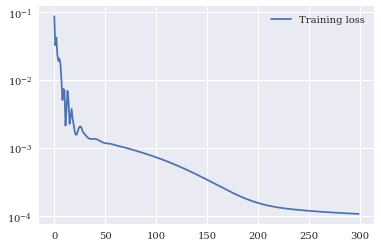

In [785]:
plt.semilogy(hist, label="Training loss")
plt.legend()
plt.show()

In [786]:
# make predictions
y_test_pred = model(x_test)
# invert predictions

y_train_pred = scaler1.inverse_transform(y_train_pred.cpu().detach().numpy())
y_train = scaler1.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler1.inverse_transform(y_test_pred.cpu().detach().numpy())
y_test = scaler1.inverse_transform(y_test.cpu().detach().numpy())


In [787]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
#ShiftedtestScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
#print('Shifted Test Score: %.2f RMSE' % (ShiftedtestScore))

Train Score: 149.93 RMSE
Test Score: 171.60 RMSE


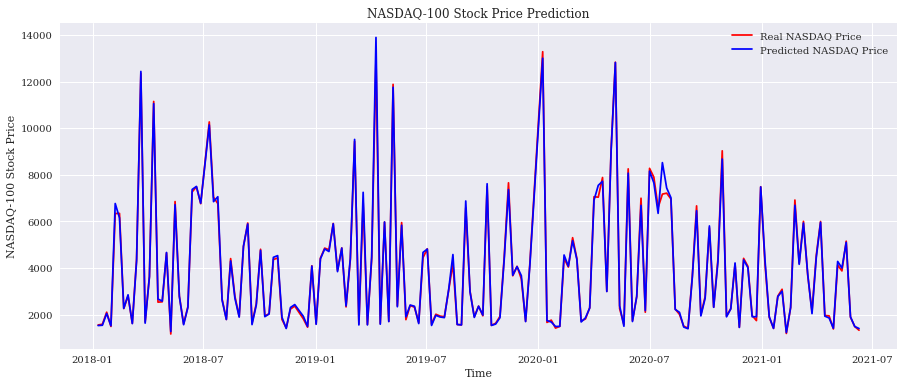

In [788]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(nasdaq[len(nasdaq)-len(y_test):].index, y_test, color = 'red', label = 'Real NASDAQ Price')
axes.plot(nasdaq[len(nasdaq)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted NASDAQ Price')
#axes.xticks(np.arange(0,394,50))
plt.title('NASDAQ-100 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('NASDAQ-100 Stock Price')
plt.legend()
#plt.savefig('ibm_pred.png')
plt.show()

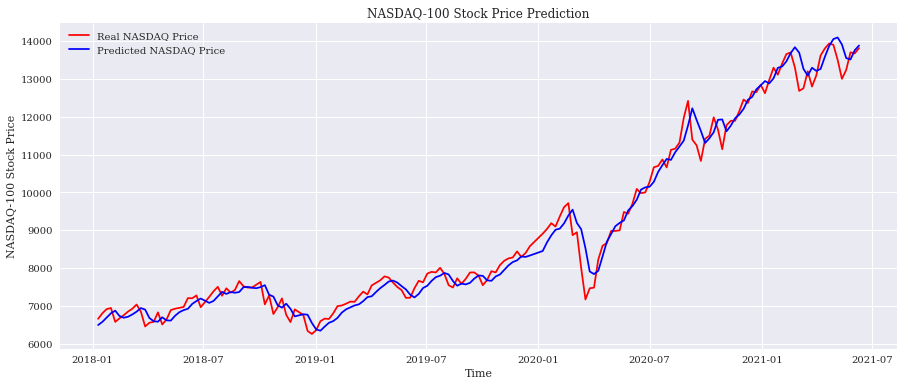

In [789]:
[_, _, x_test, y_test], rand_perm = load_data(scaled, look_back, use_perm = False)
x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
#y_test = torch.from_numpy(y_test).type(torch.Tensor).to(device)
y_test_pred = model(x_test)
y_test_pred = scaler1.inverse_transform(y_test_pred.cpu().detach().numpy())
y_test = scaler1.inverse_transform(y_test)
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(nasdaq[len(nasdaq)-len(y_test):].index, y_test, color = 'red', label = 'Real NASDAQ Price')
axes.plot(nasdaq[len(nasdaq)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted NASDAQ Price')
#axes.xticks(np.arange(0,394,50))
plt.title('NASDAQ-100 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('NASDAQ-100 Stock Price')
plt.legend()

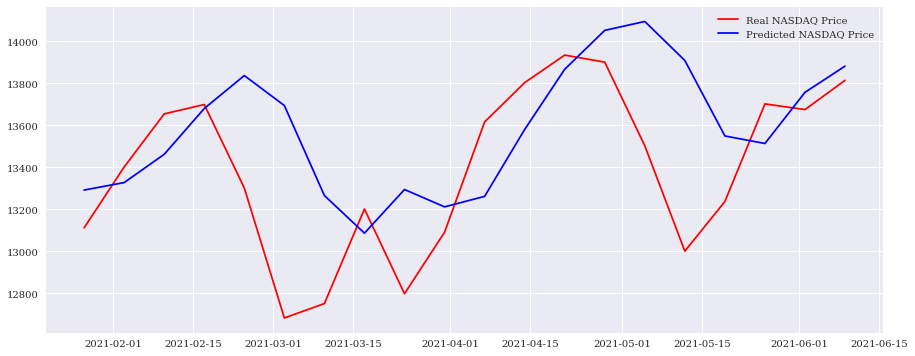

In [790]:
last = 20
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(nasdaq[-last:].index, y_test[-last:], color = 'red', label = 'Real NASDAQ Price')
axes.plot(nasdaq[-last:].index, y_test_pred[-last:], color = 'blue', label = 'Predicted NASDAQ Price')
plt.legend()

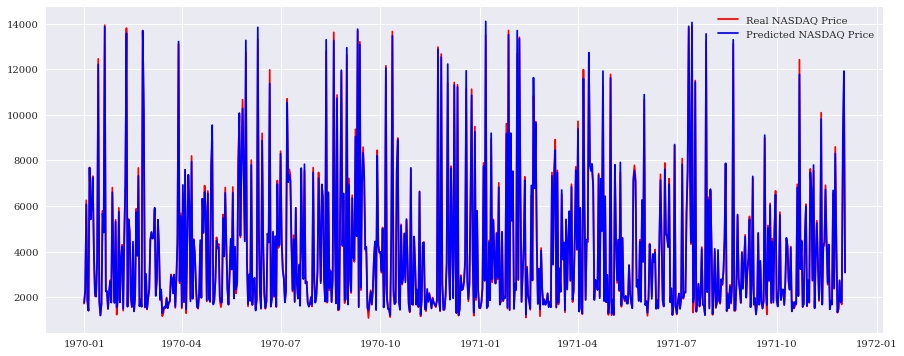

In [795]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(nasdaq[look_back:look_back+len(y_train)].index, y_train.reshape(-1), color = 'red', label = 'Real NASDAQ Price')
axes.plot(nasdaq[look_back:look_back+len(y_train)].index, y_train_pred.reshape(-1), color = 'blue', label = 'Predicted NASDAQ Price')
plt.legend()

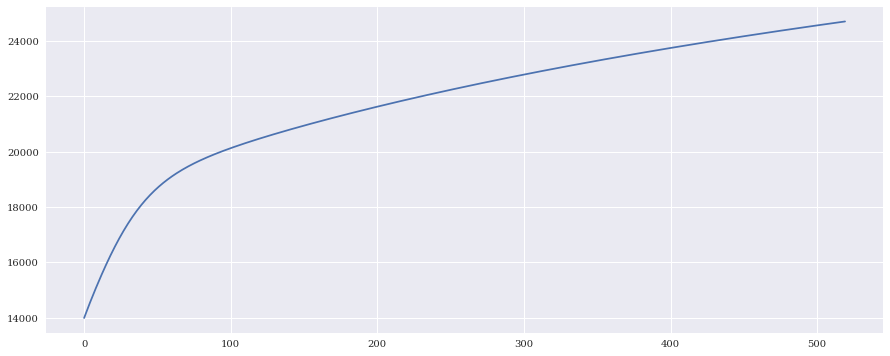

In [852]:
data_raw = nasdaq.values  # convert to numpy array
predictions = []
n = 52*10
#print(data_raw)
data = np.array(data_raw[len(data_raw) - look_back:])
x_test = data.reshape(1,data.shape[0],data.shape[1])
x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
for _ in range(n):
    y_test_pred = model(x_test)
    tmp = torch.tensor([[[y_test_pred[0,0].item(),2*x_test[0,-1,1].item()-x_test[0,-2,1].item()]]]).to(device)
    #x_test = np.concatenate((data_raw,tmp),axis=0,dtype='object')
    x_test = torch.cat((x_test,tmp),1)[:,1:,:]
    ##print(x_test.shape)
    y_test_pred = scaler1.inverse_transform(y_test_pred.cpu().detach().numpy())
    predictions.append(y_test_pred.item())
#print(predictions)
figure, axes = plt.subplots(figsize=(15, 6))
axes.plot(predictions)
#next_week_forecast = model(data)